In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from torch.utils.data import DataLoader
import os
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
from dataset.sentinel import *
from models.conv_ae import *
import torch
import random
from torchvision.transforms import transforms as T
from pathlib import Path
from config import *
from utils import *

import numpy as np
import platform

architecture='conv_ae'

In [2]:
exp_dict = exp_name_folders(path =esa_exploration, architecture='conv_ae')
for k in exp_dict.keys():
    print('num selection:{} - exp name:{}'.format(k, exp_dict[k]))

num selection:0 - exp name:4_wheel_system_01-25-23:10:09:11_conv_extended_params_sl_16


In [3]:
select_exp = '0'
added_path = exp_dict[select_exp]
model_results_path = esa_exploration + '{}/{}'.format(architecture, added_path)
print('selected experiment:', added_path)

selected experiment: 4_wheel_system_01-25-23:10:09:11_conv_extended_params_sl_16


In [4]:
files = os.listdir(model_results_path)
model_list, summary = find_models(files, model_results_path)

summary path: /home/robertomorelli/time_series_anomaly_detection/model_results/esa_exploration/conv_ae/4_wheel_system_01-25-23:10:09:11_conv_extended_params_sl_16/summary.csv


In [5]:
files = os.listdir(model_results_path)
model_list, summary = find_models(files, model_results_path)

summary path: /home/robertomorelli/time_series_anomaly_detection/model_results/esa_exploration/conv_ae/4_wheel_system_01-25-23:10:09:11_conv_extended_params_sl_16/summary.csv


In [8]:
summary.reset_index().head(10)

,index,Unnamed: 0,name,parameters_number,train_loss,val_loss
0,49,29,"trainCONVAE_ee688_00001_1_activation=Relu,batc...",41255,0.012423,0.012780
1,48,15,"trainCONVAE_ee688_00049_49_activation=Relu,bat...",41255,0.012589,0.012926
2,47,38,"trainCONVAE_ee688_00006_6_activation=Relu,batc...",41255,0.012589,0.012964
3,46,37,"trainCONVAE_ee688_00000_0_activation=Relu,batc...",43835,0.012318,0.013033
4,45,11,"trainCONVAE_ee688_00014_14_activation=Relu,bat...",43835,0.012376,0.013096
5,44,31,"trainCONVAE_ee688_00034_34_activation=Relu,bat...",41255,0.013450,0.013834
6,43,8,"trainCONVAE_ee688_00041_41_activation=Relu,bat...",41255,0.015319,0.015536
7,42,39,"trainCONVAE_ee688_00038_38_activation=Relu,bat...",41255,0.015245,0.015789
8,41,40,"trainCONVAE_ee688_00017_17_activation=Relu,bat...",41255,0.014807,0.016983
9,40,45,"trainCONVAE_ee688_00018_18_activation=Relu,bat...",41255,0.015151,0.017490


In [9]:
rank = 0
model_name_path = select_by_rank(rank, model_results_path, summary)
print(os.path.join(model_name_path))

trainCONVAE_ee688_00001_1_activation=Relu,batch_size=100,epochs=500,filter_num=64,kernel_size=3,latent_dim=50,lr=0.0009,lr_patienc_2023-01-25_10-09-39/checkpoint_000024/model.pt


In [6]:
checkpoint  = torch.load(os.path.join(model_results_path, model_name_path))
params_conf = checkpoint['param_conf']
cfg = checkpoint['cfg']

/home/robertomorelli/anaconda3/envs/fdir/lib/python3.8/site-packages/torch/cuda/__init__.py:123: UserWarning: 
    Found GPU0 NVIDIA GeForce GTX TITAN Black which is of cuda capability 3.5.
    PyTorch no longer supports this GPU because it is too old.
    The minimum cuda capability supported by this library is 3.7.
    
  warnings.warn(old_gpu_warn % (d, name, major, minor, min_arch // 10, min_arch % 10))
/home/robertomorelli/anaconda3/envs/fdir/lib/python3.8/site-packages/torch/cuda/__init__.py:123: UserWarning: 
    Found GPU1 NVIDIA GeForce GTX TITAN Black which is of cuda capability 3.5.
    PyTorch no longer supports this GPU because it is too old.
    The minimum cuda capability supported by this library is 3.7.
    
  warnings.warn(old_gpu_warn % (d, name, major, minor, min_arch // 10, min_arch % 10))


In [7]:
if platform.node()=='leonard':
    device='cpu'
else:
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda:0" if use_cuda else "cpu")

In [8]:
#cols = params_conf['columns']
cols = cfg['dataset']['columns']
sequence_length = params_conf['sequence_length']
batch_size = params_conf['batch_size']
predict = params_conf['predict']
use_cuda = torch.cuda.is_available()
out_window = params_conf['out_window']

n_features = params_conf['n_features']
scaled = params_conf['scaled']
sampling_rate = params_conf['sampling_rate']

columns_subset = params_conf['columns_subset']
dataset_subset = params_conf['dataset_subset']

dataset = params_conf['dataset']
train_val_split = params_conf['train_val_split']

target = params_conf['target']
batch_size = params_conf['batch_size']
sequence_length = params_conf['sequence_length']
out_window = params_conf['out_window']
predict = params_conf['predict']
activation = params_conf['activation']
kernel_size = params_conf['kernel_size']
filter_num = params_conf['filter_num']
latent_dim = params_conf['latent_dim']
n_layers = params_conf['n_layers']

In [9]:
model = CONV_AE(in_channel=1,heigth=params_conf['sequence_length'], width=len(cfg['dataset']['columns']),
                        kernel_size=params_conf['kernel_size'], filter_num=params_conf['filter_num'],
                 latent_dim=params_conf['latent_dim'], \
        n_layers=params_conf['n_layers'], activation = params_conf['activation']).to(device)
model.load_state_dict(checkpoint['model_state_dict'])
par_nums = checkpoint['parameters_number']
model.to(device).eval()
print(count_parameters(model))

Initializing conv2d weights with Kaiming He normal
Initializing conv2d weights with Kaiming He normal
CONV_AE(
  (encoder): Encoder(
    (nn_enc): Sequential(
      (enc_lay_0): Sequential(
        (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (3): ReLU()
      )
      (enc_lay_1): Sequential(
        (0): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (3): ReLU()
      )
      (enc_lay_2): Sequential(
        (0): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 

In [14]:
transform = T.Compose([
                       T.ToTensor(),
                       ])
dataset_name = os.path.join(data_path.strip('..'), "all_2016-2018_clean_std_4s.pkl")
df_train, df_test, train_iter, test_iter = \
read_dataset_conv(dataset_name, cfg['dataset']['scaled'],cfg['dataset']['columns_subset']
                  , cfg['dataset']['dataset_subset'], cfg['dataset']['columns'], 
                 cfg['dataset']['train_val_split'], cfg['dataset']['sequence_length']
                  , cfg['dataset']['sequence_length'],  predict=False,
                 batch_size=4, transform=transform )

In [18]:
num_batch=20
print('time horizon {}'.format(num_batch*params_conf['sequence_length']))
x, shift = unrolling_batches_conv(num_batch, test_iter, sequence_length=params_conf['sequence_length']
                             , cols=cfg['dataset']['columns'])

time horizon 320


In [19]:
yo = model(x.to(device)).squeeze()
xs = torch.squeeze(x)

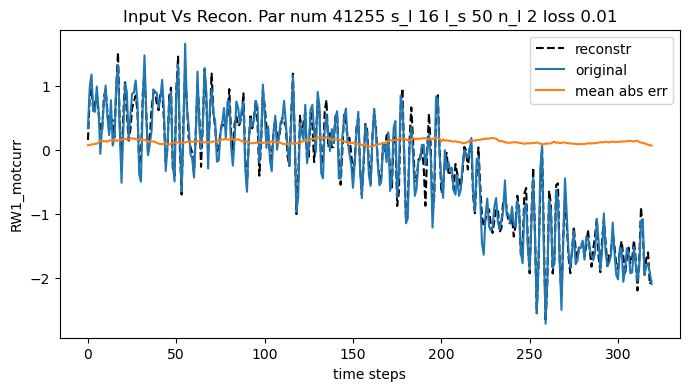

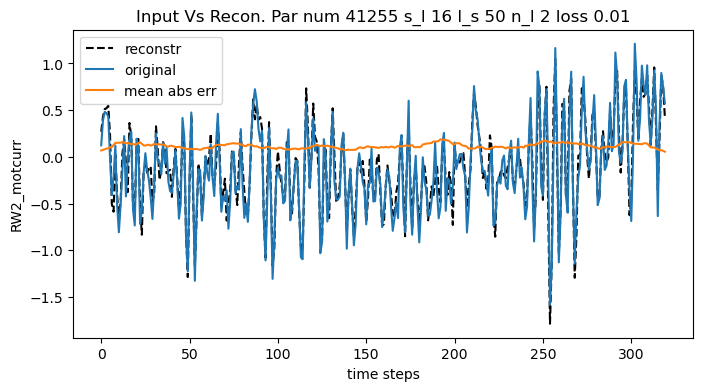

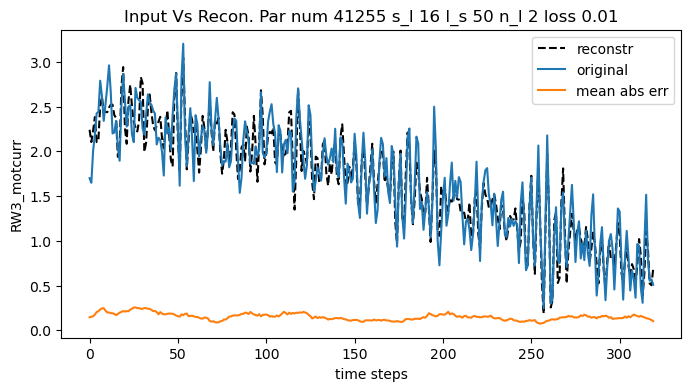

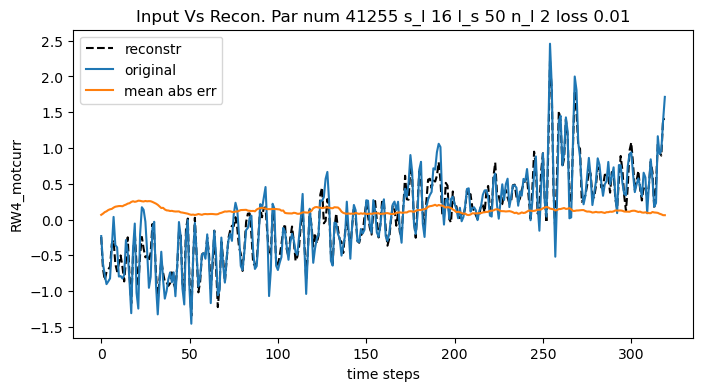

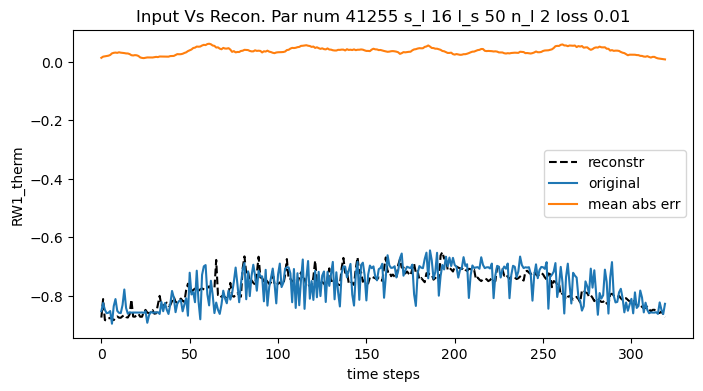

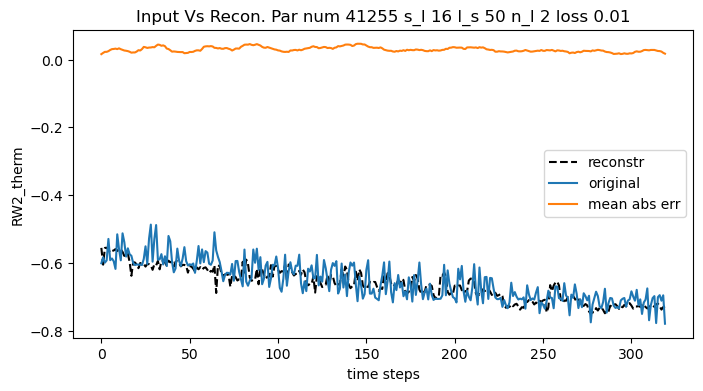

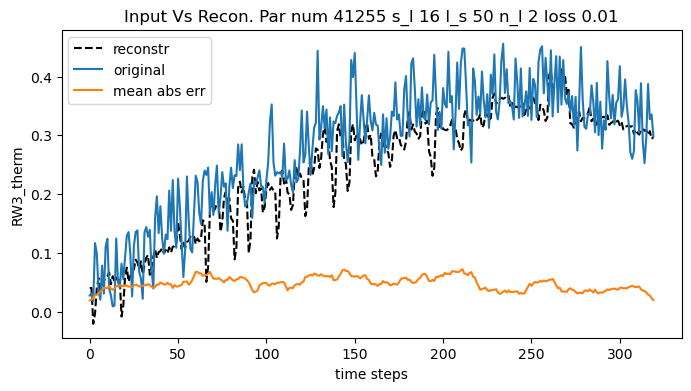

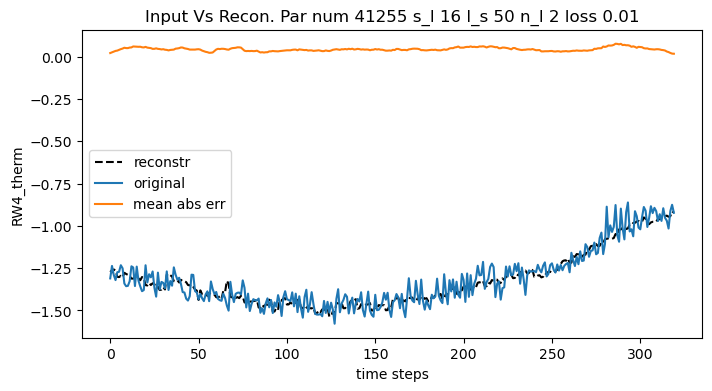

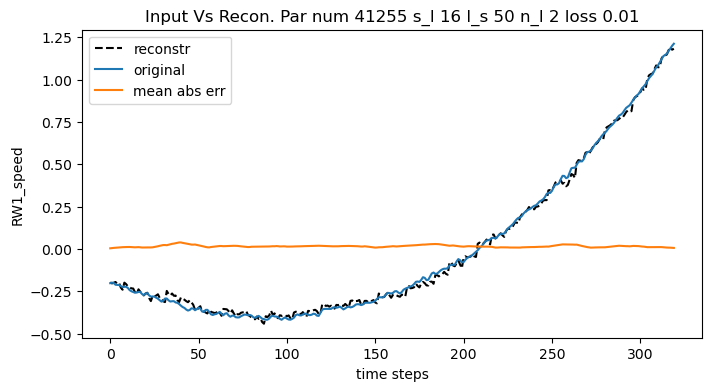

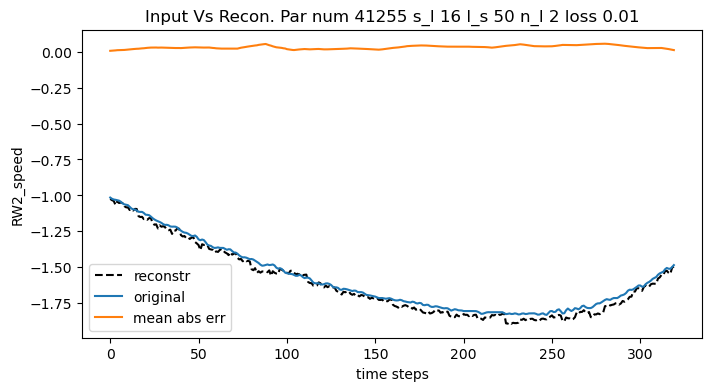

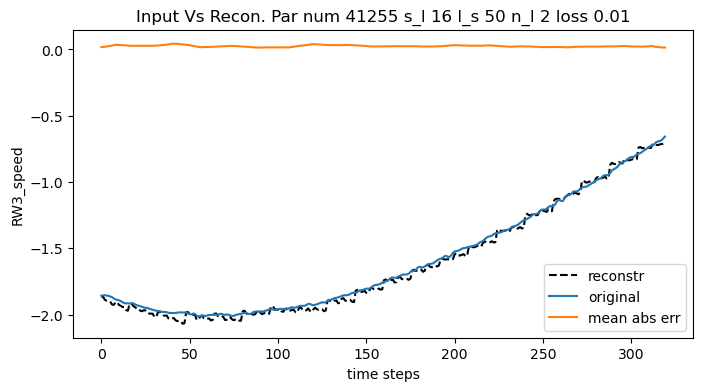

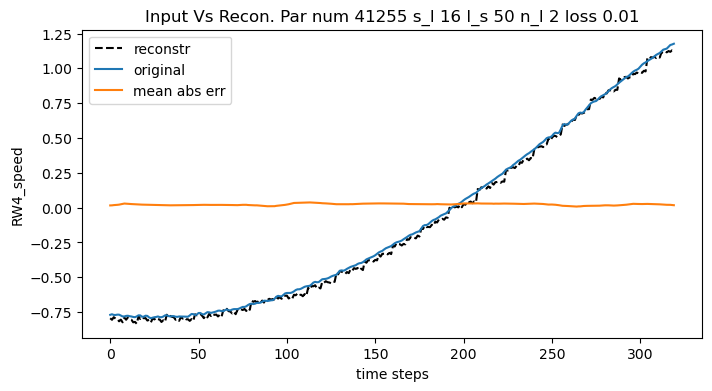

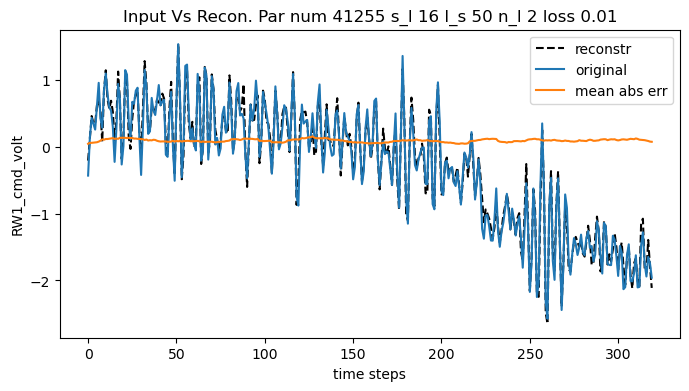

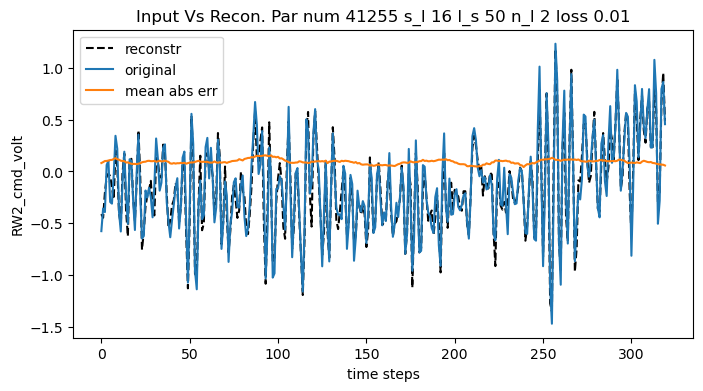

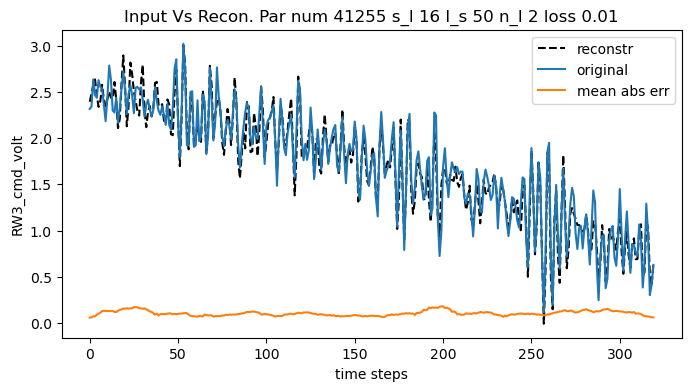

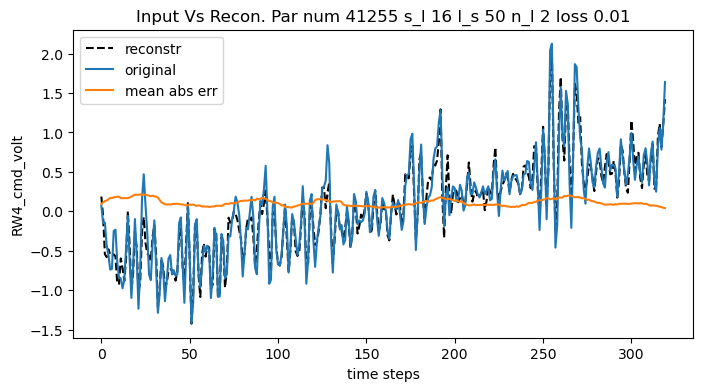

In [20]:
for i in range(x.shape[2]):
    fig, ax = plt.subplots(1,1, figsize=(8,4))

    ax.plot(yo.flatten(0,1)[:,i].to("cpu").detach().numpy(), 
               linestyle='--', label='reconstr', color='black')
    ax.plot(xs.flatten(0,1)[:,i].to("cpu").detach().numpy(), label ='original')
    x_i = xs.flatten(0,1)[:,i]
    y_o = yo.flatten(0,1)[:,i]

    loss_u = torch.nn.L1Loss(reduction='none')(y_o, x_i)
    loss_u = moving_average(loss_u.to("cpu").detach().numpy(), params_conf['sequence_length'])


    ax.plot(loss_u, label ='mean abs err')
    ax.set_xlabel('time steps')
    ax.set_ylabel('{}'.format(cfg['dataset']['columns'][i]))
    try:
        ax.set_title('Input Vs Recon. Par num {} s_l {} l_s {} n_l {} loss {}'\
                        .format(par_nums, params_conf['sequence_length'], 
                                params_conf['latent_dim'], params_conf['n_layers'],
                                #params_conf['embedding_dim'],
                                np.round(checkpoint['loss'],2)))    
    except:
        ax.set_title('Input Vs Recon. Par num {} s_l {} l_s {} n_l {}loss {}'\
                        .format(par_nums, params_conf['sequence_length'], 
                                params_conf['latent_dim'], params_conf['n_layers'],
                                #np.round(checkpoint['loss'],2)
                               ))    
        
    ax.legend()
